In [1]:
import torch  # PyTorch is based on the Torch library

from torch.utils.data.dataset import random_split
from torch.utils.data.dataloader import DataLoader

import torchvision
import torchvision.transforms as T  
from torchvision.datasets import EMNIST  # The dataset we will be working with
from torchvision.utils import make_grid

In [2]:
import matplotlib.pyplot as plt    # To plot the images and graphs
# To produce the output directly below the cell it is run
%matplotlib inline  

In [3]:
train_dataset = EMNIST(root = '/', train = True, split = 'letters', transform = T.ToTensor(), download = True)

Extracting /EMNIST/raw/emnist.zip to /EMNIST/raw
Processing byclass


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [4]:
test_dataset = EMNIST(root = '/', train = False, split = 'letters', transform = T.ToTensor(), download = True)

In [7]:

image, label = train_dataset[0]
image.shape

torch.Size([1, 28, 28])

In [8]:
input_size = 28*28  # size of the images
output_size = len(train_dataset.classes)  
input_size, output_size

(784, 26)

Text(0.5, 1.0, '23')

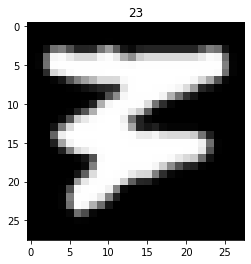

In [9]:
plt.imshow(image[0, :, :], cmap = 'gray') # We are plotting a 2D graph so we just need the 28*28 part
plt.title(label)

In [10]:
class Transpose_Image:
    def __call__(self, tensor):
        return tensor.transpose(1,2)    # Interchanging the values at 1st and 2nd index

In [11]:
train_dataset = EMNIST(root = '/', train = True, split = 'letters', transform = T.Compose([T.ToTensor(), Transpose_Image()]), download = True)
test_dataset = EMNIST(root = '/', train = False, split = 'letters', transform = T.Compose([T.ToTensor(), Transpose_Image()]), download = True)

Text(0.5, 1.0, '23')

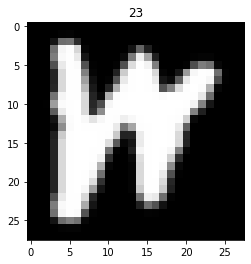

In [12]:
image, label = train_dataset[0]
plt.imshow(image[0, :, :], cmap = 'gray')
plt.title(label)

In [13]:
random_seed = 42
# Sets the seed of the random number generator to a fixed value so as to produce reproducible results
torch.manual_seed(random_seed)

In [14]:
val_size = 5000
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(119800, 5000)

In [15]:
batch_size = 128

In [16]:
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 3, pin_memory = True) 
val_loader = DataLoader(val_ds, batch_size = batch_size, num_workers = 3, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = 3, pin_memory = True)

Shape of Images :  torch.Size([128, 1, 28, 28])


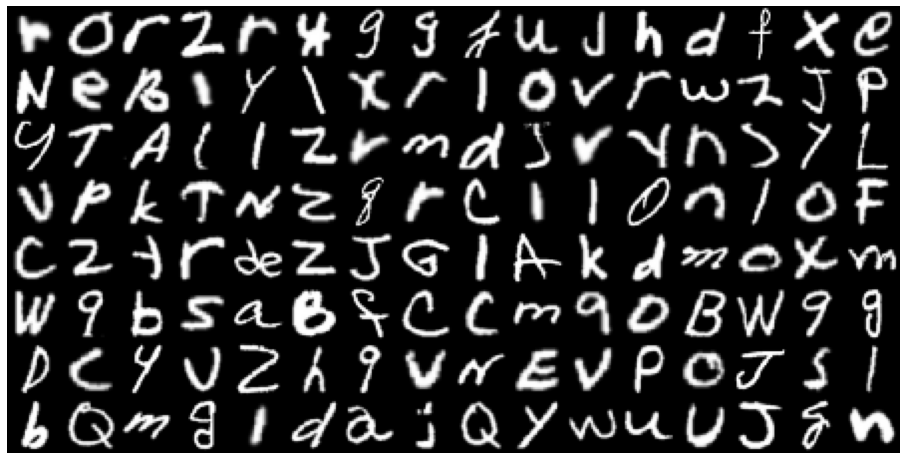

In [17]:
for images, labels in train_loader:
  print("Shape of Images : ", images.shape)
  plt.figure(figsize = (16, 16))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 16, padding = 0).permute(1, 2, 0))  # since the representation of NumPy arrays and Tensors are different
                                                                         # we have to change the shape from (1, 28, 28) -> (28, 28, 1)
  break

In [18]:
# Check if GPU's available and required CUDA drivers are installed or not
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [19]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)   # Performance gain by transferring data asynchronously

In [20]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, self.device)   # Yield a batch of data after moving it to the device

  def __len__(self):
    return len(self.dl)                     # Number of batches

In [21]:
train_ddl = DeviceDataLoader(train_loader, device)
val_ddl = DeviceDataLoader(val_loader, device)
test_ddl = DeviceDataLoader(test_loader, device)

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
def find_accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)                   # Takes the prediction with the maximum probability
  return ((preds == labels).sum()).item() / len(preds)     # Calculates the number of predictions that were correct

In [24]:
class Base_Class(nn.Module):
  def training_batch(self, batch):
    images, labels = batch
    labels = to_device(torch.tensor([x-1 for x in labels]), device)
    outputs = self.forward(images)
    loss = F.cross_entropy(outputs, labels)
    return loss

  def validation_batch(self, batch):
    images, labels = batch
    labels = to_device(torch.tensor([x-1 for x in labels]), device)
    outputs = self.forward(images)
    loss = F.cross_entropy(outputs, labels).item()
    accuracy = find_accuracy(outputs, labels)
    return {'val_loss' : loss, 'val_accuracy' : accuracy}

  def validation_end_epoch(self, outputs):
    epoch_loss = sum([x['val_loss'] for x in outputs]) / len(outputs)
    epoch_accuracy = sum([x['val_accuracy'] for x in outputs]) / len(outputs)
    return {'epoch_loss' : epoch_loss, 'epoch_accuracy' : epoch_accuracy}

In [25]:
class EMNIST(Base_Class):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace=True),    # Inplace saves memory
        nn.BatchNorm2d(8),        # Normalize the activations across n channels
        nn.Conv2d(8, 32, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2), # 32*14*14 shape

        nn.Conv2d(32, 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(2), # 256*7*7 shape

        nn.Flatten(),             # Flatten the image for the linear layers
        nn.Linear(256*7*7, 512),
        nn.ReLU(),
        nn.Linear(512, 32),
        nn.ReLU(),
        nn.Linear(32, 26)
    )

  def forward(self, images):
    return self.network(images)

In [26]:
model = EMNIST()
to_device(model, device)

EMNIST(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_di

In [27]:
@torch.no_grad()
def validate(model, val_ddl):
  model.eval()
  outputs = [model.validation_batch(batch) for batch in val_ddl]
  return model.validation_end_epoch(outputs)

def fit(model, epochs, learning_rate, train_ddl, val_ddl, optimization_func = torch.optim.SGD):
  history = []
  optimizer = optimization_func(model.parameters(), learning_rate)
  for epoch in range(epochs):
    model.train()
    for batch in train_ddl:
      loss = model.training_batch(batch)
      loss.backward()                 # Feedback our model is receiving 
      optimizer.step()                # Update parameters
      optimizer.zero_grad()           # Clears old gradients otherwise we'd just accumulate previous gradients
    result = validate(model, val_ddl) 
    history.append(result)            # Storing the history
    print('Epoch: {}, Validation loss: {:.5f}, Validation accuracy: {:.5f}'.format(epoch, result['epoch_loss'], result['epoch_accuracy']))
  return history

In [28]:
history = [validate(model, val_ddl)]
history

[{'epoch_accuracy': 0.0380859375, 'epoch_loss': 3.2625977754592896}]

In [29]:
history += fit(model, 5, 0.1, train_ddl, val_ddl)

Epoch: 0, Validation loss: 0.18774, Validation accuracy: 0.94199
Epoch: 1, Validation loss: 0.17385, Validation accuracy: 0.93984
Epoch: 2, Validation loss: 0.17558, Validation accuracy: 0.93906
Epoch: 3, Validation loss: 0.17318, Validation accuracy: 0.94766
Epoch: 4, Validation loss: 0.17640, Validation accuracy: 0.94219


In [30]:
history += fit(model, 5, 0.003, train_ddl, val_ddl)

Epoch: 0, Validation loss: 0.15780, Validation accuracy: 0.95156
Epoch: 1, Validation loss: 0.15656, Validation accuracy: 0.95215
Epoch: 2, Validation loss: 0.15709, Validation accuracy: 0.95176
Epoch: 3, Validation loss: 0.15712, Validation accuracy: 0.95215
Epoch: 4, Validation loss: 0.15749, Validation accuracy: 0.95234


In [31]:
history += fit(model, 5, 0.0001, train_ddl, val_ddl)

Epoch: 0, Validation loss: 0.15765, Validation accuracy: 0.95234
Epoch: 1, Validation loss: 0.15773, Validation accuracy: 0.95215
Epoch: 2, Validation loss: 0.15759, Validation accuracy: 0.95273
Epoch: 3, Validation loss: 0.15753, Validation accuracy: 0.95293
Epoch: 4, Validation loss: 0.15754, Validation accuracy: 0.95293


Text(0.5, 1.0, 'Accuracy vs No. of Epochs')

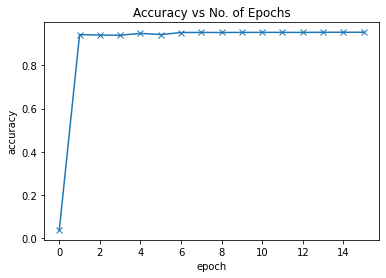

In [32]:

accuracies = [x['epoch_accuracy'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of Epochs')

In [33]:
validate(model, test_ddl)

{'epoch_accuracy': 0.9493865030674846, 'epoch_loss': 0.16080451661655165}

In [34]:
torch.save(model.state_dict(), 'model.pth')